<h1 align = 'center'> Predictive Heart Disease Modelling using EMR Data</h1>

<b>Avinash Pasupulate</b>
<br><a href = mailto:avinash.pasupulate@gmail.com>avinash.pasupulate@gmail.com</a>
<br><a href = https://www.linkedin.com/in/avinashpasupulate/>Linkedin</a>

<h3>Status : </h3>
<br><b>Pending</b>
<ul>
<li> Optimization & evaluation pending</li>
<li>Feature Selection with domain research and algorithms</li>
<li> ROC</li>
<li> Model Explanation techniques</li>
<li> Model Deployment</li>

In [331]:
#importing required packages
import re
import os
#import copy
import numpy as np
import pandas as pd
#from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [332]:
#get a list of files in the data folder
cwd = os.getcwd()
os.listdir(cwd+r'/data')

['cleveland.data',
 'Index.1',
 'cleve.mod',
 'heart-disease.expense',
 'heart-disease.delay',
 'bak',
 'hungarian.data',
 'new.data',
 'switzerland.data',
 'ask-detrano',
 'heart-disease.cost',
 'long-beach-va.data',
 'WARNING',
 'processed.cleveland.data',
 'reprocessed.hungarian.data',
 'processed.switzerland.data',
 'heart-disease.README',
 'heart-disease.group',
 'Index',
 'heart-disease.names',
 'processed.hungarian.data',
 'processed.va.data']

In [333]:
#using the cleaveland dataset to build the model
#reading file with data description and data
with open(cwd+r'/data/cleve.mod', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('%'):
            print(line.rstrip('\n'))

% ======================================================================
% John Gennari
% 3/13/90
%
% This is Dr. Detrano's database modified to be a real MIXED dataset.
%
% Attributes: 8 symbolic, 6 numeric.
%  Age; sex; chest pain type (angina, abnang, notang, asympt)
%  Trestbps (resting blood pres); cholesteral; fasting blood sugar < 120
%  (true or false); resting ecg (norm, abn, hyper); max heart rate; 
%  exercise induced angina (true or false); oldpeak; slope (up, flat, down)
%  number of vessels colored (???); thal (norm, fixed, rever). Finally, the
%  class is either healthy (buff) or with heart-disease (sick).
%
% Original atts: 
%   age; sex (1,0); cp (1-4); trestbps; chol; fbs (1,0); restecg (0,1,2); 
%   thalach; exang (1,0); oldpeak; slope (1,2,3); ca; thal (3,6,7);
%   class att: 0 is healthy, 1,2,3,4 is sick.
% ======================================================================


<h1>Describing Variables</h1>

<h1>Processign Raw Data</h1>

In [334]:
#extracted data from the text file
l = ['age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal target target1']
with open(cwd+r'/data/cleve.mod', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if (line.startswith('%')) or (len(line)==0):
            None
        else:
            l.extend([re.sub('\s+',' ',''.join(line.rstrip('\n')))])

In [335]:
df = pd.DataFrame([i.split(' ') for i in l])
df.columns = df.iloc[0]

In [336]:
df = df.drop(df.index[0:2])
df = df.drop(df.index[-1]).reset_index(drop = True)

#dropping target1 column 
df.drop('target1', axis = 1, inplace = True)

In [337]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,buff
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,sick
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,sick
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,buff
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,buff


In [338]:
#replacing missing values with na and converting dtypes for columns
df.replace('?', np.nan, inplace = True)
df['age'] = df['age'].astype(float, errors = 'ignore')
df['trestbps'] = df['trestbps'].astype(float, errors = 'ignore')
df['chol'] = df['chol'].astype(float, errors = 'ignore')
df['thalach'] = df['thalach'].astype(float, errors = 'ignore')
df['oldpeak'] = df['oldpeak'].astype(float, errors = 'ignore')
df['ca'] = df['ca'].astype(float, errors = 'ignore')

df['target'] = df['target'].astype('category', errors = 'ignore')
df['target'] = df['target'].cat.codes.astype(int)
df['sex'] = df['sex'].astype('category', errors = 'ignore')
df['sex'] = df['sex'].cat.codes.astype(int)
df['fbs'] = df['fbs'].astype('category', errors = 'ignore')
df['fbs'] = df['fbs'].cat.codes.astype(int)

In [339]:
df.dtypes

0
age         float64
sex           int64
cp           object
trestbps    float64
chol        float64
fbs           int64
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
target        int64
dtype: object

<h2>Encoding Categorical Variables and Creating Dummy Variables</h2>

In [340]:
#converting to dummy data
mod_df = pd.get_dummies(df, drop_first = True)

In [341]:
mod_df.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'oldpeak', 'ca',
       'target', 'cp_angina', 'cp_asympt', 'cp_notang', 'restecg_hyp',
       'restecg_norm', 'exang_true', 'slope_flat', 'slope_up', 'thal_norm',
       'thal_rev'],
      dtype='object')

In [342]:
mod_df.head()

,age,sex,trestbps,chol,fbs,thalach,oldpeak,ca,target,cp_angina,cp_asympt,cp_notang,restecg_hyp,restecg_norm,exang_true,slope_flat,slope_up,thal_norm,thal_rev
0,63.0,1,145.0,233.0,1,150.0,2.3,0.0,0,1,0,0,1,0,0,0,0,0,0
1,67.0,1,160.0,286.0,0,108.0,1.5,3.0,1,0,1,0,1,0,1,1,0,1,0
2,67.0,1,120.0,229.0,0,129.0,2.6,2.0,1,0,1,0,1,0,1,1,0,0,1
3,37.0,1,130.0,250.0,0,187.0,3.5,0.0,0,0,0,1,0,1,0,0,0,1,0
4,41.0,0,130.0,204.0,0,172.0,1.4,0.0,0,0,0,0,1,0,0,0,1,1,0


In [343]:
#replacing null values in the data frame

mod_df.loc[(mod_df.isnull().any(axis=1))&(mod_df['target']==0), 'ca'] = round(mod_df['ca'][mod_df['target']==0].mean())

mod_df.loc[(mod_df.isnull().any(axis=1))&(mod_df['target']==1), 'ca'] = round(mod_df['ca'][mod_df['target']==1].mean())


In [344]:
mod_df.dtypes

age             float64
sex               int64
trestbps        float64
chol            float64
fbs               int64
thalach         float64
oldpeak         float64
ca              float64
target            int64
cp_angina         uint8
cp_asympt         uint8
cp_notang         uint8
restecg_hyp       uint8
restecg_norm      uint8
exang_true        uint8
slope_flat        uint8
slope_up          uint8
thal_norm         uint8
thal_rev          uint8
dtype: object

<h2>Creating Test & Train Datasets</h2>

In [345]:
#splitting data into train and test set with a random seed
x_train, x_test, y_train, y_test = train_test_split(mod_df.drop('target', axis = 1),
                                                    mod_df['target'], random_state = 28,
                                                    test_size = 0.2)

<h1>Building Classification Models</h1>

The below listed classification methods would be used for predicting heart disease,

<ul>
    <li>Logistic Regression</li>
    <li>Decision Tree Classifier</li>
    <li>Random Forest Classifier</li>
    <li>K Nearest Neighbour (KNN) Classifier</li>
    <li>Support Vector Machine Classifier</li>
    <li>Naïve Bayes Classifier</li>
</ul>

<h2>Logistic Regression</h2>

In [346]:
from sklearn.linear_model import LogisticRegression

In [366]:
log_mod = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [367]:
log_fit = log_mod.fit(x_train, y_train)

In [386]:
print("Logistic Regression Accuracy : {:.2f}%"
      .format(log_fit.score(x_test, y_test)*100, 1))

Logistic Regression Accuracy : 85.25%


<h2>Decision Tree Classifier</h2>

In [396]:
from sklearn.tree import DecisionTreeClassifier

In [397]:
dt_mod = DecisionTreeClassifier()

In [398]:
dt_fit = dt_mod.fit(x_train, y_train)

In [407]:
print('Decision Tree Accuracy : {:.2f}%'
      .format(dt_fit.score(x_test, y_test)*100))

Decision Tree Accuracy : 77.05%


<h2>Random Forest Classifier</h2>

In [550]:
from sklearn.ensemble import RandomForestClassifier

In [558]:
rfc_mod = RandomForestClassifier(n_estimators = 1000, random_state = 28)

In [559]:
rfc_fit = rfc_mod.fit(x_train, y_train)

In [560]:
print('Random Forest Classifier Accuracy : {:.2f}%'
      .format(rfc_fit.score(x_test, y_test)*100))

Random Forest Classifier Accuracy : 88.52%


<h2>K Nearest Neighbour (KNN) Classifier</h2>

In [468]:
from sklearn.neighbors import KNeighborsClassifier

In [546]:
#running knn with different k to get the best fit
score = []
for i in range(1,20):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_fit = knn_model.fit(x_train, y_train)
    score.append(knn_fit.score(x_test, y_test))
print('Max KNN accuracy score : {:.2f}% with a k of {}'.format((max(score)*100),(score.index(0.7049180327868853)+1)))

Max KNN accuracy score : 70.49% with a k of 1


<h2>Support Vector Machine Classifier</h2>

In [475]:
from sklearn.svm import SVC

In [547]:
svc_mod = SVC(gamma = 'scale')

In [548]:
svc_fit = svc_mod.fit(x_train, y_train)

In [549]:
print('Support Vector Machine Classifier Accuracy : {:.2f}%'
      .format(svc_fit.score(x_test, y_test)*100))

Support Vector Machine Classifier Accuracy : 67.21%


<h2>Naïve Bayes Classifier</h2>

In [483]:
from sklearn.naive_bayes import GaussianNB

In [484]:
gnb_model = GaussianNB()

In [485]:
gnb_fit = gnb_model.fit(x_train, y_train)

In [489]:
print('Naive Bayes Classifier Accuracy : {:.2f}%'
      .format(gnb_fit.score(x_test, y_test)*100))

Naive Bayes Classifier Accuracy : 88.52%


<h3>Selecting the models with the highest accuracy for further optimization,</h3>

<ul>
    <li>Random Forest Classifier  -  88.52%</li>
    <li>Naïve Bayes Classifier    -  88.52%</li>
    <li>Logistic Regression       -  85.25%</li>
</ul>
        

<h1>Evaluation Metrics</h1>

<h2>F1 Score</h2>

Another way to calculate the accuracy score (below is not necssarily required),

In [499]:
from sklearn.metrics import f1_score

<h3>Random Forest Classifier </h3>

In [496]:
rfc_pred = rfc_fit.predict(x_test)
rfc_true = y_test

In [506]:
f1_score(rfc_true, rfc_pred, average = 'micro')*100

88.52459016393442

<h3>Naïve Bayes Classifier</h3>

In [497]:
gnb_pred = gnb_fit.predict(x_test)
gnb_true = y_test

In [505]:
f1_score(gnb_true, gnb_pred, average = 'micro')*100

88.52459016393442

<h3>Logistic Regression</h3>

In [498]:
log_pred = log_fit.predict(x_test)
log_true = y_test

In [504]:
f1_score(log_true, log_pred, average = 'micro')*100

85.24590163934425

<h2>Confusion Matrix</h2>

In [511]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

<h3>Random Forest Classifier </h3>

Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

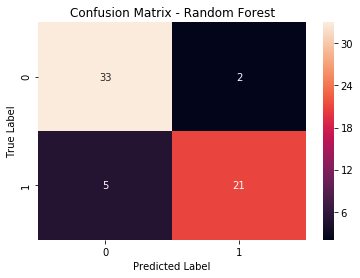

In [596]:
cm_rfc = confusion_matrix(rfc_true, rfc_pred)
ax = plt.subplot()
sns.heatmap(cm_rfc, annot = True, ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix - Random Forest')

In [606]:
sensitivity = (cm_rfc[1,1]/(cm_rfc[1,1]+cm_rfc[1,0]))
specificity = (cm_rfc[0,0]/(cm_rfc[0,0]+cm_rfc[0,1]))
print('Sensitivity {:.2f}% and specificity {:.2f}%'.format(sensitivity*100, specificity*100))



Sensitivity 80.77% and specificity 94.29%


<h3>Naïve Bayes Classifier</h3>

Text(33.0, 0.5, 'True Label')

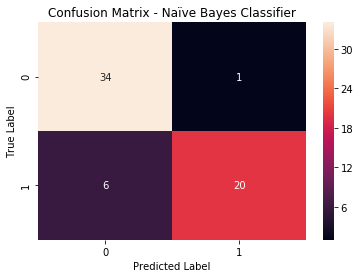

In [607]:
cm_gnb = confusion_matrix(gnb_true, gnb_pred)
ax = plt.subplot()
sns.heatmap(cm_gnb, annot = True, ax = ax)
ax.set_title('Confusion Matrix - Naïve Bayes Classifier')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

In [608]:
sensitivity = (cm_gnb[1,1]/(cm_gnb[1,1]+cm_gnb[1,0]))
specificity = (cm_gnb[0,0]/(cm_gnb[0,0]+cm_gnb[0,1]))
print('Sensitivity {:.2f}% and specificity {:.2f}%'.format(sensitivity*100, specificity*100))


Sensitivity 76.92% and specificity 97.14%


<h3>Logistic Regression</h3>

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

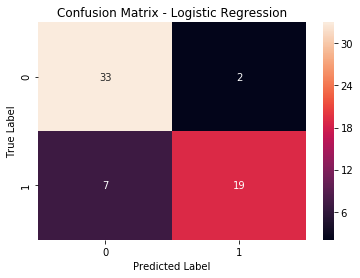

In [610]:
ax = plt.subplot()
cm_log = confusion_matrix(log_true, log_pred)
sns.heatmap(cm_log, annot = True, ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix - Logistic Regression')

In [611]:
sensitivity = (cm_log[1,1]/(cm_log[1,1]+cm_log[1,0]))
specificity = (cm_log[0,0]/(cm_log[0,0]+cm_log[0,1]))
print('Sensitivity {:.2f}% and specificity {:.2f}%'.format(sensitivity*100, specificity*100))


Sensitivity 73.08% and specificity 94.29%


<h3>Choosing one of the two top performing models to optimize further,</h3>
<ul>
    <li>Random Forest Classifier  -  88.52%</li>
    <li>Naïve Bayes Classifier    -  88.52%</li>
</ul>
Choosing <b>Random Forest Classifier</b> to proceed further with optimization and feature selection, since it has good sensitivity and specificity values

In [571]:
#use random search and grid search cv to optimize hyperparameters

rfc_mod1 = RandomForestClassifier(n_estimators=1000, random_state=28)
rfc_fit1 = rfc_mod1.fit(x_train, y_train)


In [581]:
feature = x_train.columns
imp = rfc_mod1.feature_importances_

In [587]:
sorted(list(zip(feature, imp)), key = lambda x: x[1], reverse=True)

[('cp_asympt', 0.10577280770523095),
 ('thalach', 0.10425522882282302),
 ('ca', 0.10424045940029966),
 ('thal_norm', 0.10081743163868219),
 ('oldpeak', 0.08870086534719865),
 ('chol', 0.08022914969365642),
 ('age', 0.07668987577289489),
 ('thal_rev', 0.07057256854644561),
 ('trestbps', 0.06898128801273704),
 ('slope_up', 0.043611587297471756),
 ('exang_true', 0.040114982655945),
 ('slope_flat', 0.02707155076937926),
 ('sex', 0.020756491535999767),
 ('cp_notang', 0.019065639958351262),
 ('restecg_norm', 0.015563655578814997),
 ('restecg_hyp', 0.013917548911638492),
 ('cp_angina', 0.011490366675873925),
 ('fbs', 0.008148501676557457)]

In [570]:
print(sel_features)

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'cp_asympt',
       'thal_norm', 'thal_rev'],
      dtype='object')
